In [1]:
from utils.loadData import loadDataWithNews
from lstm.preprocessing import dataToTimeSeriesMultiDimensional, getDatasetsMultiDimensional, normalizeAtOnce
from lstm.model import getModel, evaluateModelQuick, evaluateFinal
from lstm.visualization import visualize_loss, show_batch, show_data_simple, showRegressionExampleMultiDimensional
from lstm.callbacks import es_callback, modelckpt_callback

In [2]:
df = loadDataWithNews()
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,positive,neutral,negative
0,0,2020-12-17,21308.351563,23642.660156,21234.675781,22805.162109,22805.162109,71378606374,2,3,0
1,1,2020-12-18,22806.796875,23238.601563,22399.812500,23137.960938,23137.960938,40387896275,3,2,0
2,2,2020-12-19,23132.865234,24085.855469,22826.472656,23869.832031,23869.832031,38487546580,0,1,0
3,3,2020-12-20,23861.765625,24209.660156,23147.710938,23477.294922,23477.294922,37844228422,1,2,0
4,4,2020-12-21,23474.455078,24059.982422,22159.367188,22803.082031,22803.082031,45852713981,3,3,0


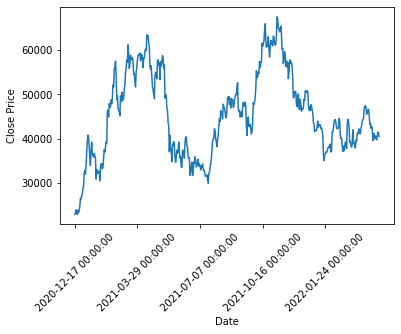

In [3]:
features = df.loc[:, df.columns != 'Date']
features = features.loc[:, features.columns != 'Unnamed: 0']
features = features.loc[:, features.columns != 'Adj Close']
normalized_data, scaler = normalizeAtOnce(features.iloc[:,:-3])
show_data_simple(features["Close"], df["Date"])

2022-04-22 17:05:52.464762: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


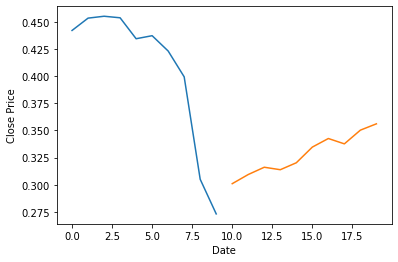

Input shape: (40, 10, 5)
Target shape: (40,)


In [4]:
config = {
    "past": 10,
    "future": 10,
    "neurons": 50,
    "batch_size": 64,
    "epochs": 20,
    "features": normalized_data.shape[1]
}

dataset_train, dataset_val, x_test, y_test = getDatasetsMultiDimensional(config, normalized_data)


for batch in dataset_val.take(1):
    inputs, targets = batch
    show_batch(inputs[0, :, 3], targets[:config["future"]], config["past"])

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

In [5]:
model = getModel(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 50)            11200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
Total params: 31,910
Trainable params: 31,910
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 0.2621 - rmse: 0.5120 - mae: 0.4639 - mape: 85.5744
Epoch 1: val_loss improved from inf to 0.07764, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 11s 490ms/step - loss: 0.2621 - rmse: 0.5120 - mae: 0.4639 - mape: 85.5744 - val_loss: 0.0776 - val_rmse: 0.2786 - val_mae: 0.2625 - val_mape: 66.7450
Epoch 2/20
5/6 [========================>.....] - ETA: 0s - loss: 0.1370 - rmse: 0.3702 - mae: 0.3141 - mape: 57.2339
Epoch 2: val_loss improved from 0.07764 to 0.01935, saving model to checkpoints/model_checkpoint.h5
6/6 [==============================] - 0s 67ms/step - loss: 0.1282 - rmse: 0.3581 - mae: 0.3029 - mape: 54.3080 - val_loss: 0.0193 - val_rmse: 0.1391 - val_mae: 0.1120 - val_mape: 27.9789
Epoch 3/20
5/6 [========================>.....] - ETA: 0s - loss: 0.0369 - rmse: 0.1922 - mae: 0.1484 - mape: 29.1187
Epoch 3: val_loss did not improve from 0.01935
6/6 [====================

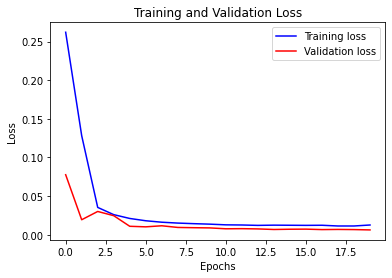

In [6]:
history = model.fit(
    dataset_train,
    epochs=config["epochs"],
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)
visualize_loss(history)

In [7]:
x, y = dataToTimeSeriesMultiDimensional(x_test, y_test[:,3], config["past"], config["future"])

In [8]:
evaluateModelQuick(model, x, y)

1/1 [==============================] - 2s 2s/step - loss: 0.0080 - rmse: 0.0895 - mae: 0.0733 - mape: 16.6073
---- TEST RESULTS ----
MSE loss - 0.008006450720131397
RMSE - 0.08947877585887909


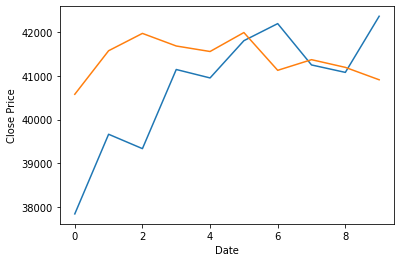

In [9]:
showRegressionExampleMultiDimensional(x[0], y[0], model, scaler)

In [10]:
evaluateFinal(getModel, dataset_train, dataset_val, config, "regression_with_rich_features")

Training Started...
Iterations:
1
2
3
4
5
6
7
8
9
10
Done
